In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import os

In [2]:
SIGNAL_NAME = ['LL','RL','LP','RP','ML']

EEG_FEATS = [['Fp1','F7','T3','T5','O1'],
        ['Fp2','F8','T4','T6','O2'],
        ['Fp1','F3','C3','P3','O1'],
        ['Fp2','F4','C4','P4','O2'],
        ['Fz','Cz','Pz']]

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data
def butter_bandpass_filter(data, lowcut = 0.4, highcut = 20, fs = 200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

def sos_bandpass_filter(data, lowcut = 0.4, highcut = 20, fs = 200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype="band", analog=False, output="sos")
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def sos_lowpass_filter(data, cutoff, fs = 200, order=4):
    normal_cutoff = cutoff / (0.5 * fs)
    sos = butter(order, normal_cutoff, btype="low", analog=False, output="sos")

    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

    
def get_center_raw_eeg(eeg_signal_dict, offset_sec=0):
    num_row_per_sec = 200
    center_offset_sec = offset_sec + 20
    center_len = 10

    col_start = int(center_offset_sec * num_row_per_sec)
    center_raw_eeg_dict = dict()
    for key, value in eeg_signal_dict.items():
        # get the sub df of col_start : col_start + num_row_per_sec * center_len
        center_raw_eeg_dict[key] = value.iloc[col_start : col_start + num_row_per_sec * center_len]
    return center_raw_eeg_dict

In [3]:
train_df_path = "/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train.csv"
train_df = pd.read_csv(train_df_path)
# random select a row
# random seed is set to 0
# np.random.seed(4)
row = train_df.sample(1)
print(row)

          eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
50813  839459106          21                      64.0       995785734   

       spectrogram_sub_id  spectrogram_label_offset_seconds  label_id  \
50813                  23                             598.0  69946224   

       patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
50813       37979             LRDA             0         0         0   

       lrda_vote  grda_vote  other_vote  
50813          5          0           0  


In [4]:
eeg_path = os.path.join("/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train_eegs", str(row["eeg_id"].values[0])+'.parquet')
eeg_df = pd.read_parquet(eeg_path)

# test_eeg_id = 4117398721
# test_eeg_id = 1410654188
# test_eeg_id= 868415395
# test_eeg_id = 80952273
# test_eeg_id = 1239205061
# test_eeg_id = 3316372342
# test_eeg_id = 2009915165
# test_eeg_id = 2744456620
# test_eeg_id = 4070165861
# 406628315
# test_eeg_id = 1307362978
# test_eeg_id = 1540593350
# test_eeg_id = 1661408834
# test_eeg_id = 628259169
# # get the row of the eeg_id
# row = train_df[train_df["eeg_id"] == test_eeg_id]

# eeg_path = os.path.join("/home/maxc/workspace/kaggle-hms/hms-harmful-brain-activity-classification/train_eegs", str(test_eeg_id)+'.parquet')
eeg_df = pd.read_parquet(eeg_path)
row.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
50813,839459106,21,64.0,995785734,23,598.0,69946224,37979,LRDA,0,0,0,5,0,0


In [5]:
def band_remove(x, thres_amp= 200):
    # find the max amplitude of the signal
    max_amp = np.max(np.abs(x))

    min_left_idx = len(x)
    max_right_idx = 0
    while max_amp > thres_amp:

        # find the index of the max amplitude
        max_amp_idx = np.argmax(np.abs(x))
        # find the left and right cloest index that the amplitude is 0
        left_idx = max_amp_idx
        right_idx = max_amp_idx
        max_amp_sign = np.sign(x[max_amp_idx])
        # print(x[max_amp_idx])

        while left_idx > 0 and x[left_idx] * max_amp_sign > 0:
            left_idx -= 1

        while right_idx < len(x) and x[right_idx] * max_amp_sign > 0:
            right_idx += 1
        x[left_idx:right_idx] = 0
        max_amp = np.max(np.abs(x))
        min_left_idx = min(min_left_idx, left_idx)
        max_right_idx = max(max_right_idx, right_idx)
    return x, min_left_idx, max_right_idx


In [6]:
from scipy.signal import firwin, freqz
def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    taps = firwin(ntaps, [lowcut, highcut], fs=fs, pass_zero=False,
                  window=window, scale=False)
    return taps

In [7]:
def filter_signal(x, filter=None,  lowcut = 0.5, highcut = 20.0, order = 4):
    if filter == 'lowpass':
        x = butter_lowpass_filter(x)
    elif filter == 'soslowpass':
        x = sos_lowpass_filter(x, cutoff=highcut,fs=200 ,order = order)
    elif filter == 'sosbandpass':
        x = sos_bandpass_filter(x, lowcut=lowcut, highcut=highcut, fs=200, order=order)
    elif filter == 'bandpass_firwin':
        ntaps = 400
        taps = bandpass_firwin(ntaps, lowcut, highcut, fs=200, window='hamming')
        x = np.convolve(x, taps, mode='same')
    elif filter == 'bandpass':
        x = butter_bandpass_filter(x, lowcut=lowcut, highcut=highcut, fs=200, order=order)
        # x = quantize_data(x, 1)
    elif filter == 'bandclip':
        x = butter_bandpass_filter(x, lowcut=lowcut, highcut=highcut, fs=200, order=order)
        x = x.clip(-200, 200)
        # x = adaptive_filter(x)
    elif filter == "bandblock":
        x = butter_bandpass_filter(x, lowcut=lowcut, highcut=highcut, fs=200, order=order)
        x[x>200] = 0
        x[x<-200] = 0
    elif filter == "bandremove":
        x = butter_bandpass_filter(x, lowcut=lowcut, highcut=highcut, fs=200, order=order)
        x,block_left, block_right = band_remove(x, thres_amp= 200)
        # min_block_left = min(min_block_left, block_left)
        # max_block_right = max(max_block_right, block_right)
    return x
    #filter = None, lowcut = 0.5, highcut = 20.0, prefilter = False, order = 4

def plot_eeg_df(eeg_df, offset_sec=0, plot_offset = 1, **kwargs):
    # print(eeg_df.head())
    print(kwargs)

    eeg_signal_dict = dict()

    all_eeg_signals = []

    min_block_left = np.inf
    max_block_right = 0
    for k in range(len(SIGNAL_NAME)):
        cols = EEG_FEATS[k]
        signal_name = SIGNAL_NAME[k]
        signal_df = pd.DataFrame()
        for kk in range(len(cols) - 1):
            sub_signal_name = f"{signal_name}_{cols[kk]}-{cols[kk+1]}"


            x = eeg_df[cols[kk]].values - eeg_df[cols[kk + 1]].values
            x = filter_signal(x, **kwargs)
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1:
                x = np.nan_to_num(x, nan=m)

            signal_df[sub_signal_name] = x
            all_eeg_signals.append(x)
        eeg_signal_dict[signal_name] = signal_df

    all_eeg_signals = np.concatenate(all_eeg_signals, axis=0)
    eps = 1e-6
    # mean = np.mean(all_eeg_signals)
    # std = np.std(all_eeg_signals)

    # if filter == "bandremove" and min_block_left < max_block_right:
    #     # change the value between min_block_left and max_block_right to 0
    #     for signal_name in SIGNAL_NAME:
    #         eeg_signal_dict[signal_name].iloc[min_block_left:max_block_right] = 0

    center_raw_eeg_dict = get_center_raw_eeg(eeg_signal_dict, offset_sec=offset_sec)
    min = np.inf
    max = -np.inf
    all_eeg_signals = []
    for signal_name in SIGNAL_NAME:
        # min = np.min([min, center_raw_eeg_dict[signal_name].min().min()])
        # max = np.max([max, center_raw_eeg_dict[signal_name].max().max()])
        all_eeg_signals.append(center_raw_eeg_dict[signal_name].values)
    all_eeg_signals = np.concatenate(all_eeg_signals, axis=1)
    min = np.min(all_eeg_signals)
    max = np.max(all_eeg_signals)
    std = np.std(all_eeg_signals)
    mean = np.mean(all_eeg_signals)

    print("Min: ", min, "Max: ", max, "Mean: ", mean, "Std: ", std)


    mean = 0
    std = 100
    for signal_name in SIGNAL_NAME:
        eeg_signal_dict[signal_name] = (
            eeg_signal_dict[signal_name] - mean
        ) / (std + eps)
    center_raw_eeg_dict = get_center_raw_eeg(eeg_signal_dict, offset_sec=offset_sec)

    #plot all signals in one figure
    import matplotlib.pyplot as plt
    idx = 0
    plt.figure(figsize=(20, 10))

    for signal_name in SIGNAL_NAME:
        for col in center_raw_eeg_dict[signal_name].columns:
            offset = (18 - idx) * plot_offset
            plt.plot(center_raw_eeg_dict[signal_name][col].values + offset, label = col)
            idx+=1
        # plot a vertical line every 200 rows
        for i in range(1, 10):
            plt.axvline(x=i*200, color='r', linestyle='--')
        plt.legend()

{}
Min:  -106.979996 Max:  118.95 Mean:  -1.4068553 Std:  24.805788


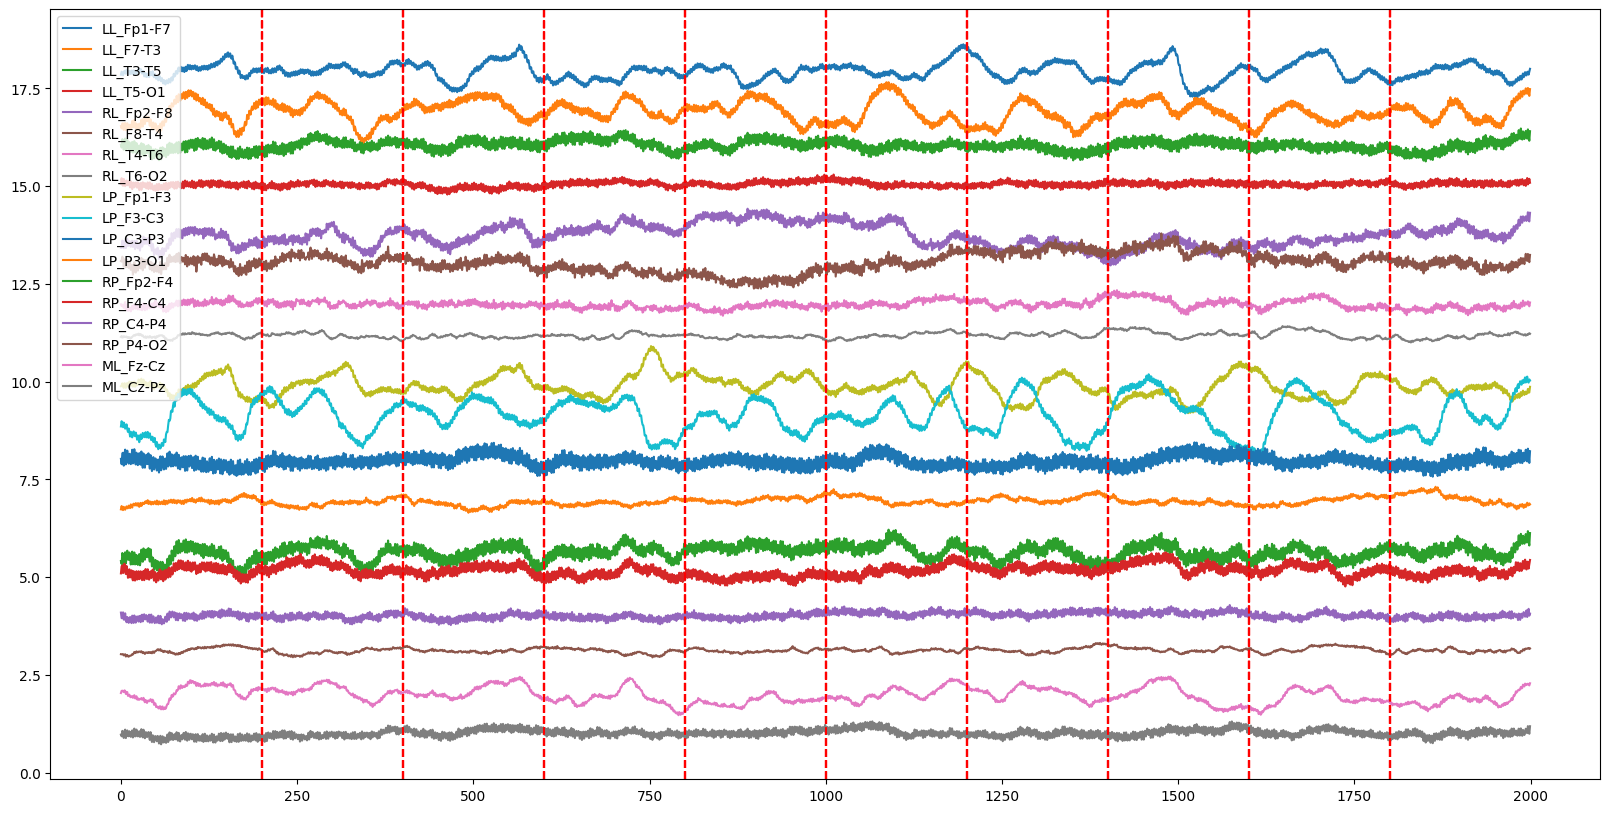

In [8]:
plot_eeg_df(eeg_df)

{'filter': 'lowpass'}
Min:  -93.36174097653266 Max:  110.06267617363955 Mean:  -1.4547049274145032 Std:  23.71589864361247


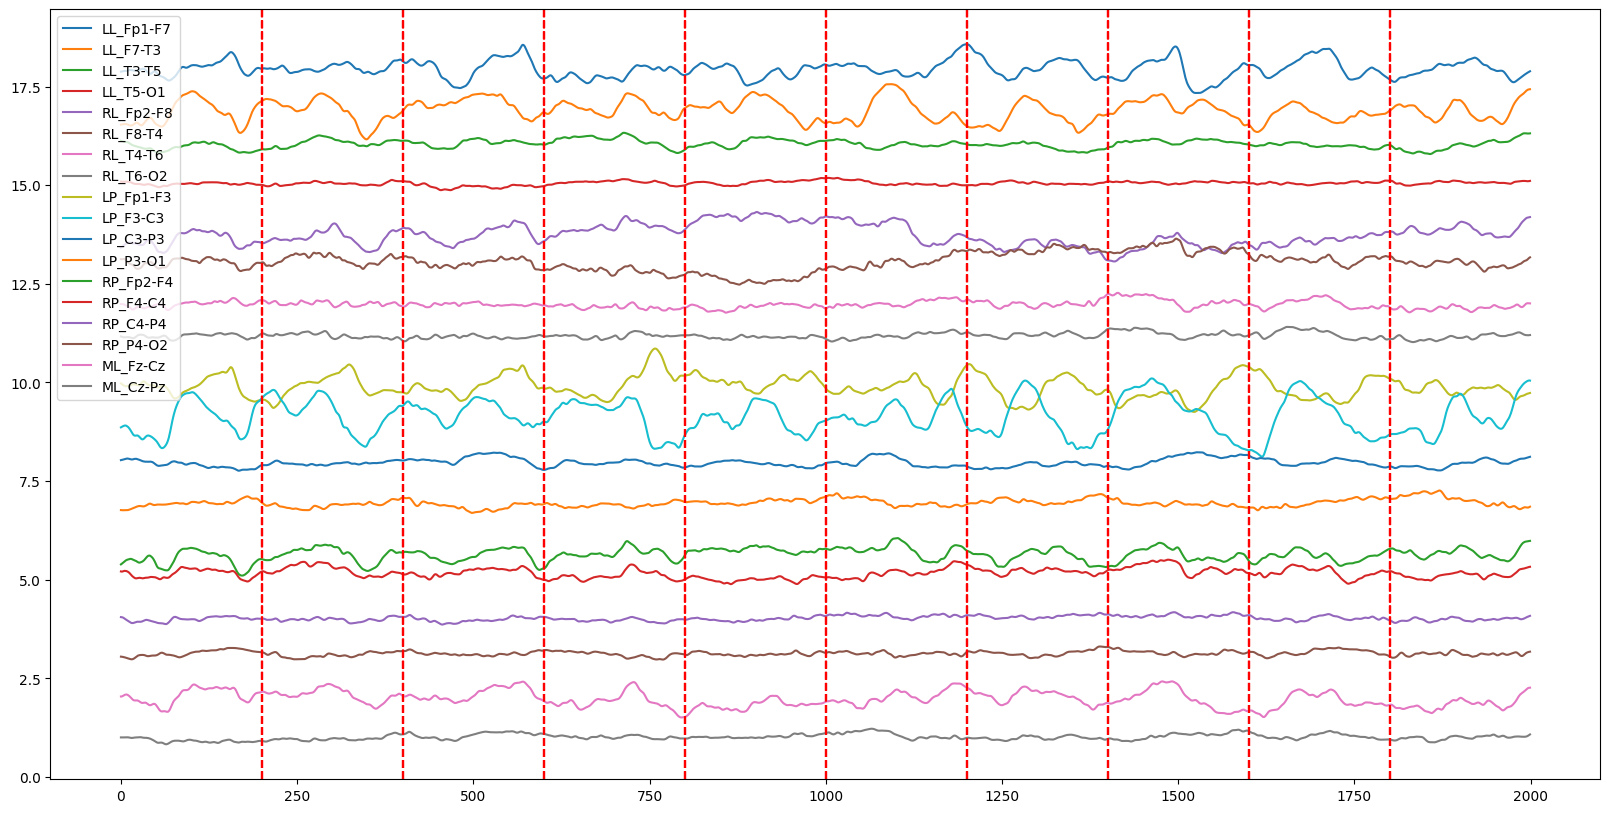

In [9]:
plot_eeg_df(eeg_df, filter = "lowpass")

{'filter': 'soslowpass'}
Min:  -93.61829512842948 Max:  110.12957543610888 Mean:  -1.4065875439174738 Std:  23.732237347049164


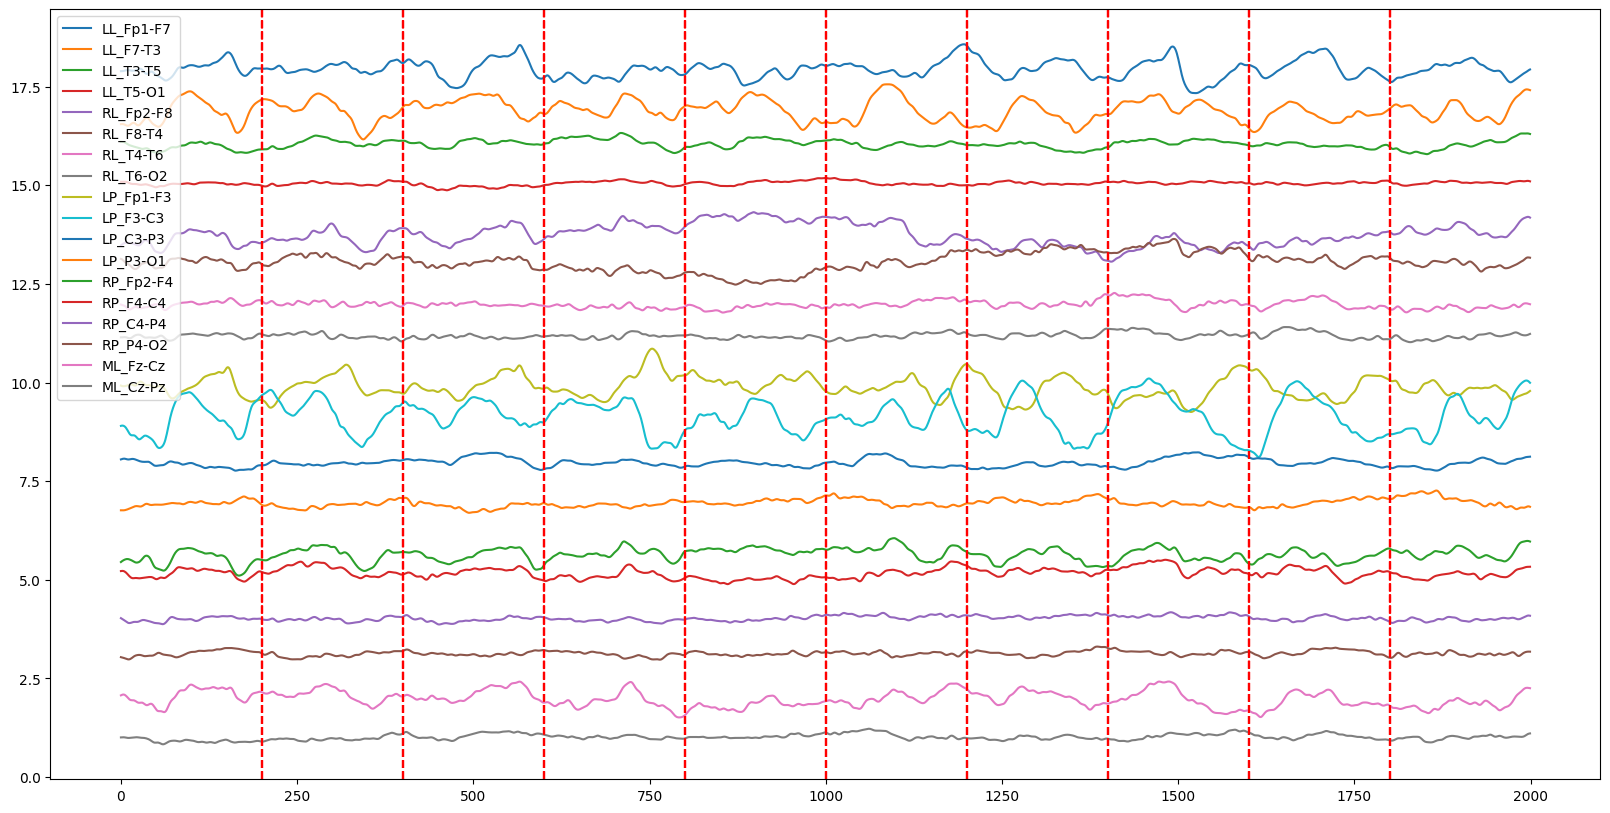

In [10]:
plot_eeg_df(eeg_df, filter = "soslowpass")

{'filter': 'bandpass', 'highcut': 20}
Min:  -86.41432747666165 Max:  119.78526154077164 Mean:  0.2296629599168199 Std:  16.71868165781052


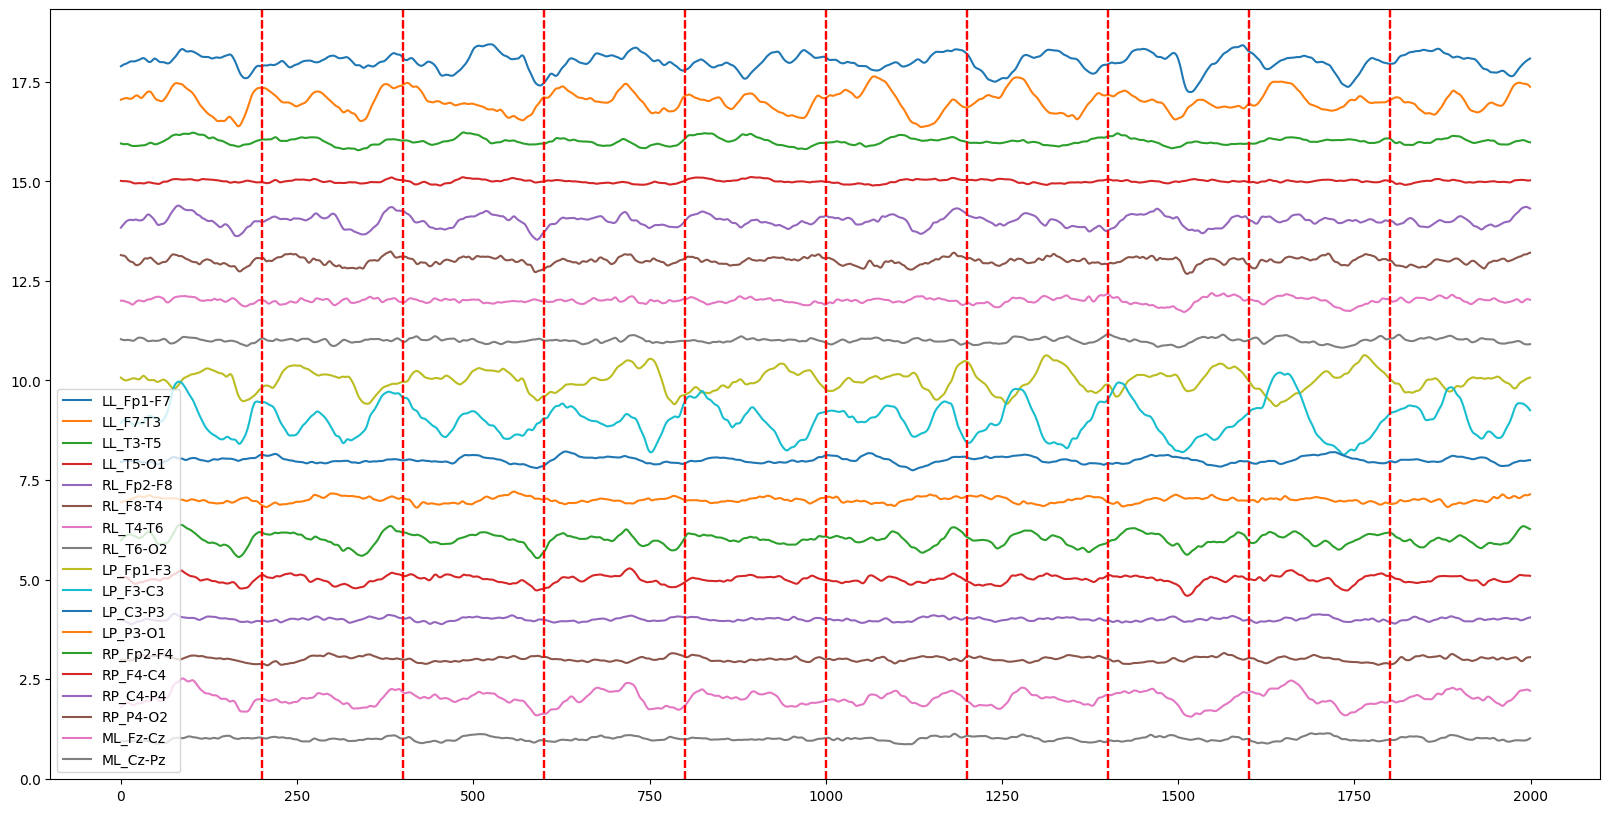

In [11]:
plot_eeg_df(eeg_df, filter = "bandpass", highcut=20)

{'filter': 'sosbandpass', 'highcut': 20}
Min:  -98.60312374651636 Max:  100.1601058245428 Mean:  -0.14115062124044056 Std:  16.648881771822555


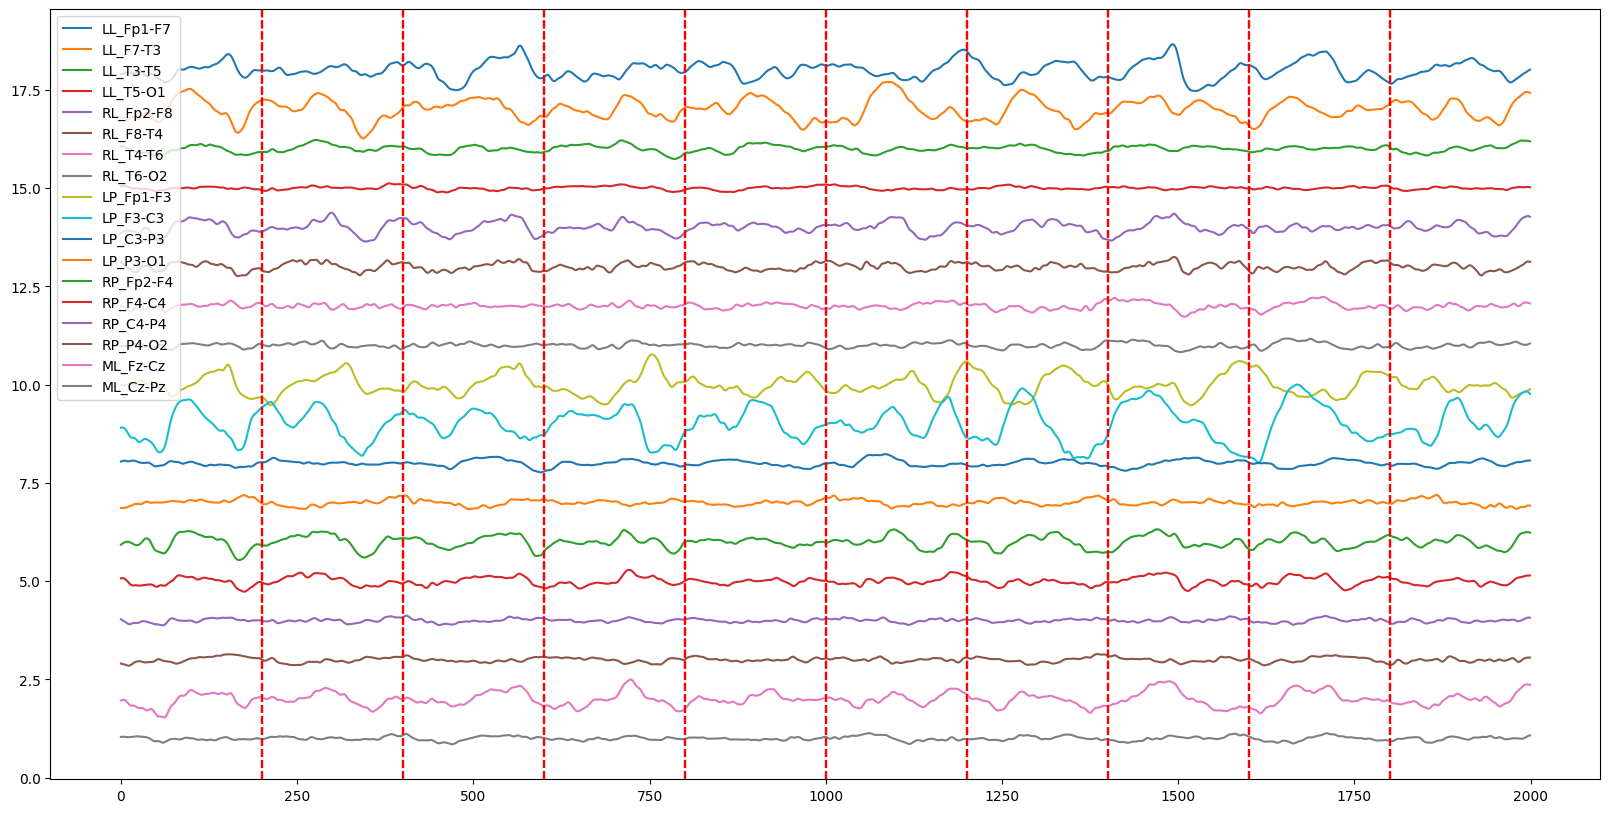

In [12]:
plot_eeg_df(eeg_df, filter = "sosbandpass", highcut=20)

{'filter': 'sosbandpass', 'highcut': 11.25}
Min:  -97.22443396924865 Max:  99.50973315762947 Mean:  -0.143004999698479 Std:  16.630609350871005


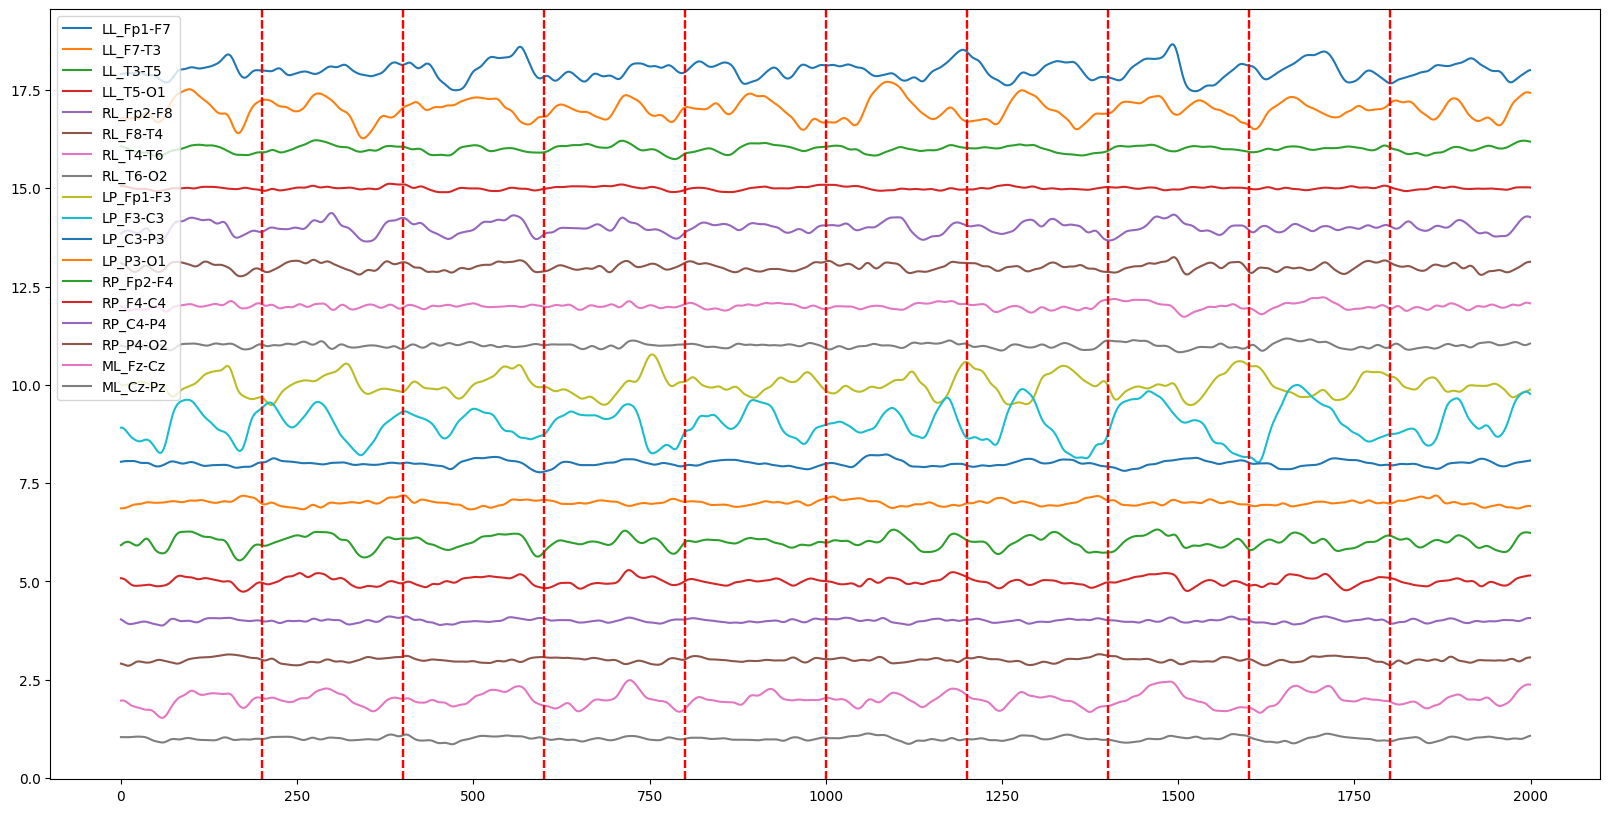

In [13]:
plot_eeg_df(eeg_df, filter = "sosbandpass", highcut=11.25)

{'filter': 'bandpass_firwin', 'highcut': 11.25}
Min:  -88.52317538126414 Max:  91.85651342815771 Mean:  -0.3280618399061645 Std:  16.08741135155742


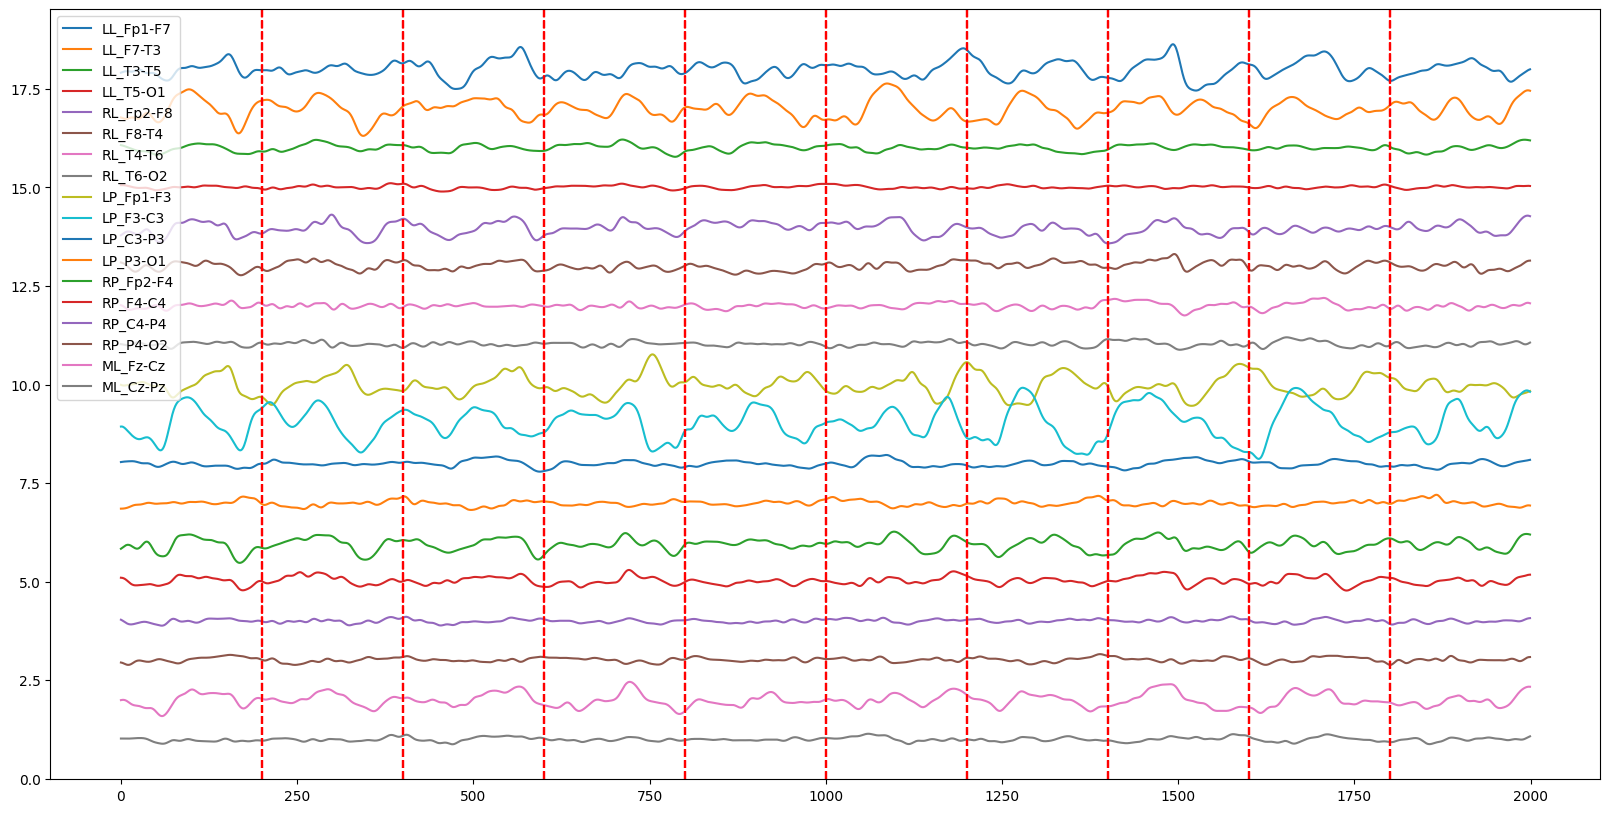

In [14]:
plot_eeg_df(eeg_df, filter = "bandpass_firwin", highcut=11.25)

In [15]:
# plot_eeg_df(eeg_df, filter = "bandclip")

In [16]:
# plot_eeg_df(eeg_df, filter = "bandblock")

{'filter': 'bandremove'}
Min:  -86.41432747666165 Max:  119.78526154077164 Mean:  0.2296629599168199 Std:  16.71868165781052


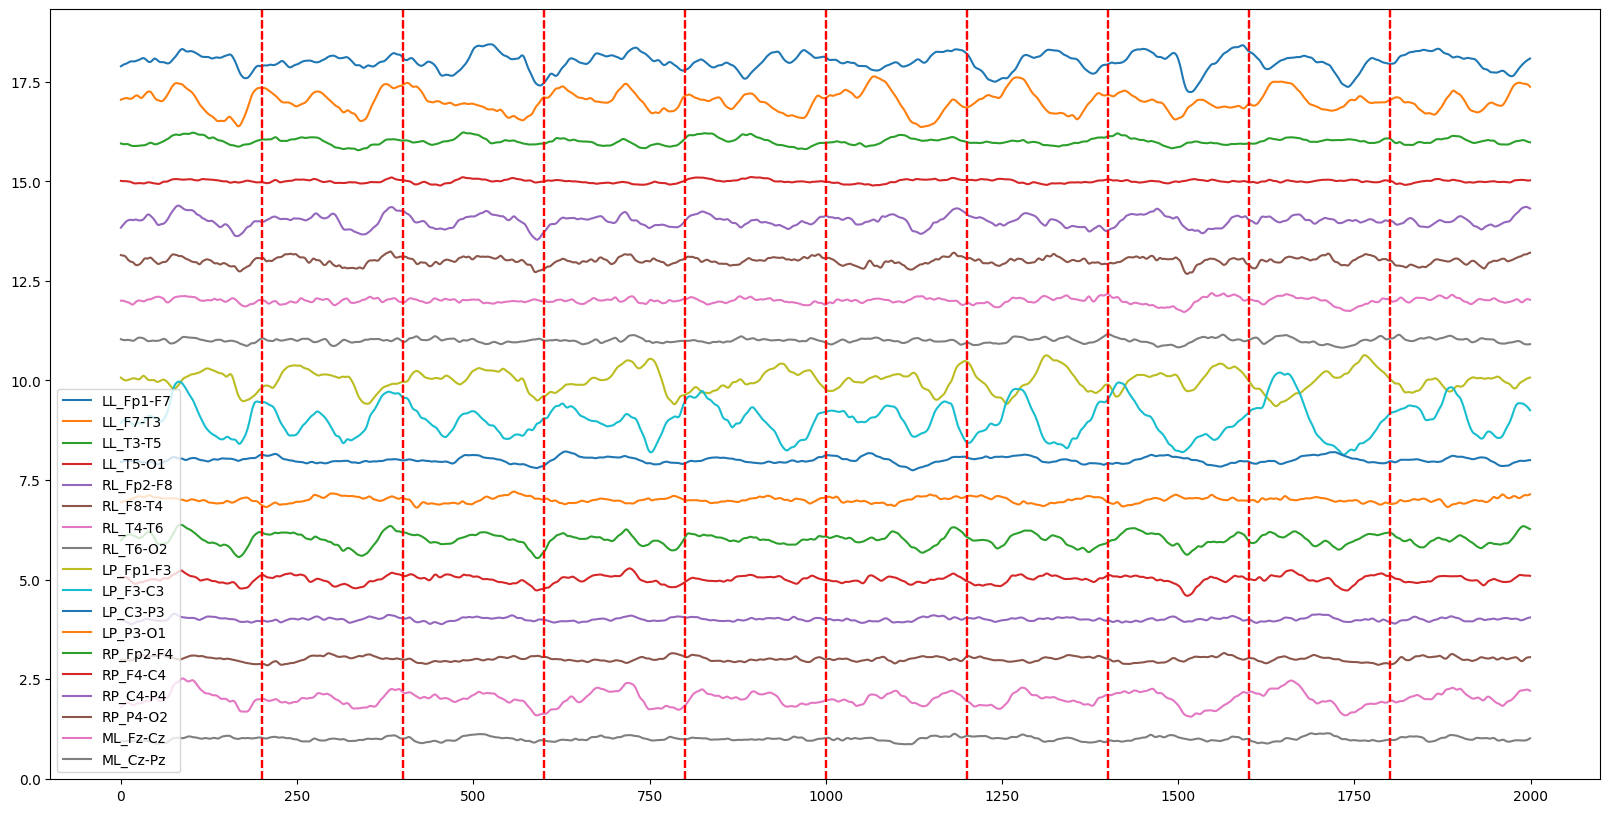

In [17]:
plot_eeg_df(eeg_df, filter = "bandremove")